# Introductie Neurale Netwerken met Keras en TensorFlow

- Originele versie: Daniel Moser (UT Southwestern Medical Center)
- Aangepast door Tijmen Muller (tijmen.muller@hu.nl) en Joost Vanstreels (joost.vanstreels@hu.nl) (2021)

Tijdens de cursus Machine Learning gaan we aan de slag met neurale netwerken en convolutionele neurale netwerken (ConvNets), ook wel bekend als deep learning. Tijdens deze workshop gaan we de basisstappen doorlopen om een simpel neuraal netwerk te maken met behulp van de populaire libraries van Google, Keras en TensorFlow.

## Inleiding

### Doel workshop

Het doel van deze workshop is om een beeld te krijgen van de werking van neurale netwerken:
- Wat zijn neurale netwerken?
- Hoe werken ze?
- Voor wat voor een type problemen kun je ze inzetten?
- Wat is het verschil met machine learning technieken zoals decision trees en kNN?
- Wat is de toegevoegde waarde van convolutionele netwerken?

### Opzet workshop

Aan de hand van theoretische uitleg en praktische codevoorbeelden gaan jullie zelfstandig aan de slag met enkele opdrachten:
1. We starten met het opzetten van een simpel neuraal netwerk dat jullie gaan *tweaken* om betere resultaten te krijgen;
2. Daarna gaan jullie het neuraal netwerk uitbreiden met meerdere lagen;
3. Ook dit model gaan jullie tweaken op zoek naar 98% accuracy;
4. Tenslotte gaan we hetzelfde proberen te realiseren met kNN.

### Werkwijze
De werkwijze is als volgt:
- Lees de uitleg goed;
- Voer de code stap-voor-stap uit;
- Voer de opdrachten uit -- de cellen die getagd zijn met `student` moet je zelf invullen;
- Voor het uitvoeren van de opdrachten heb je **geen** externe bronnen nodig: alle benodigde kennis is gegeven in dit notebook;
- Werk in Google Colab of installeer zelf de libraries (`keras` en `tensorflow`) en draai het notebook lokaal.

## Deel I. Machine learning met neurale netwerken

### Herkennen van handgeschreven cijfers

We gaan aan de slag met de *Hello World* van neurale netwerken: het herkennen van de handgeschreven cijfers van de MNIST dataset. Deze dataset bestaat uit een trainset van 60.000 plaatjes met cijfers en een testset van nog eens 10.000 plaatjes.

De plaatjes zien er als volgt uit:

<img src="https://i.imgur.com/86wacJG.png" >

### Benodigde libraries 

We hebben een aantal libraries nodig, sommigen kennen jullie al.

In [1]:
import random  
import time

import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist     # MNIST dataset is onderdeel van Keras
from keras.models import Sequential  # Het type neuraal netwerk dat we gaan gebruiken

from keras.layers.core import Dense, Dropout, Activation # Verschillende type lagen die we gaan gebruiken
from keras.utils import np_utils                         # NumPy gerelateerde tools

### Stap 1. Data exploration 

De MNIST dataset is gebundeld in Keras, we kunnen deze eenvoudig downloaden.

In [2]:
# Inladen van de dataset, deze is al gesplitst in een train- en testset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("x_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("x_test shape", x_test.shape)
print("y_test shape", y_test.shape)

x_train shape (60000, 28, 28)
y_train shape (60000,)
x_test shape (10000, 28, 28)
y_test shape (10000,)


**Let op**
Als je kijkt naar de dataset dan zie je een groot verschil met de datasets die we gezien hebben bij Computational Modelling. Daar hadden we te maken met .csv bestanden met datasets met meerdere kolommen en verschillende datatypes als inhoud. We konden kiezen welke features we als input gingen gebruiken. De inhoud van deze datasets was gestructureerd. Deze dataset bestaat eigenlijk uit 60.000 keer 784 (28 x 28) pixelwaardes... dat noemen we ongestructureerde data. 

Met matplotlib kunnen we een aantal plaatjes uit de dataset bekijken.

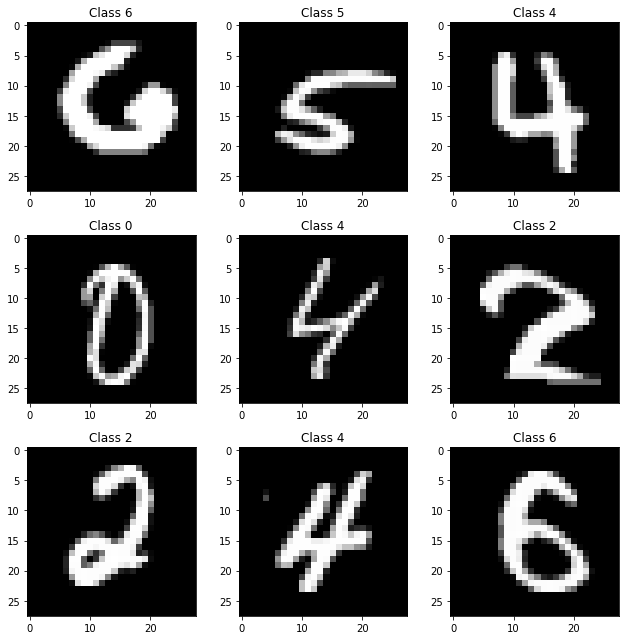

In [3]:
plt.figure(figsize=(9,9))

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(x_train))
    plt.imshow(x_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))
    
plt.tight_layout()

Een plaatje is eigenlijk niks meer dan een twee dimensionaal array met 28 x 28 grijswaardes. Elke pixel is een 8-bit integer met waardes tussen 0 (zwart) en 255 (wit). Hieronder wordt de array getoond van het getal rechtsonder in bovenstaande figuur:

In [4]:
# just a little function for pretty printing a matrix
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# now print!        
matprint(x_train[num])

0  0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  
0  0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  
0  0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  
0  0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  
0  0  0  0  0  0  0  0    0    0    0    8   43  237  253  253  193   69    4    0    0    0    0   0  0  0  0  0  
0  0  0  0  0  0  0  0    0    0    0  114  252  252  252  252  253  252  135    0    0    0    0   0  0  0  0  0  
0  0  0  0  0  0  0  0    0    0  107  253  252  252  252  235  253  252  251  135    4    0    0   0  0  0  0  0  
0  0  0  0  0  0  0  0    0   16  221  253  252  252  139   14   84  184  252  252  113    0    0   0  0  0  0  0  
0  0  0  0  0  0  0  0    0  108  252  253  252  235   14    0    0   14

### Stap 2. Data preparation

#### Features

De input voor het neuraal netwerk is het plaatje. Dat plaatje bestaat eigenlijk uit 784 features: alle 784 pixels. Zo'n 28 x 28 matrix is niet handig als input voor een neuraal netwerk. We moeten er een vector van maken door _flattening_ toe te passen (zie figuur hieronder). We krijgen dan een vector met een lengte van 784 (= 28 x 28).

Daarnaast is het handig om de data te normaliseren. De Z-score gebruiken is hier niet logisch, dus we gaan indexeren waarbij 0 (het minimum) de waarde 0 wordt, 255 (het maximum) wordt 1 en alle tussenliggende waardes worden lineair gemapt naar een waarde tussen 0 en 1.

<img src='https://i.imgur.com/l049B93.png' >

In [5]:
# Let op: we schakelen hier over van een kleine letter naar een hoofdletter, zodat de originele
# trainingsdata in `x_train` beschikbaar blijft!

X_train = x_train.reshape(60000, 784) # reshape de 60.000 plaatjes van 28 x 28 matrices naar 60.000 784-lengte vectoren.
X_test = x_test.reshape(10000, 784)

X_train = X_train.astype('float32')   # verander datatype van integers naar 32-bit floats
X_test = X_test.astype('float32') 

X_train /= 255                        # normaliseer de pixels door de waarde te delen door de maximale waarde (= 255)
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


#### Target

De target variabele is een 0, 1, 2, ... of 9. Dat zijn de verschillende klasses of categorieën. Kijk bijvoorbeeld maar eens naar de inhoud van een willekeurig item uit y_train:

Dit is een: 2


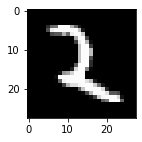

In [6]:
i = random.randrange(60000)
plt.figure(figsize=(2,2))
plt.imshow(X_train[i].reshape(28,28), cmap='gray', interpolation='none')
print("Dit is een:", y_train[i])

Bij CM hebben we altijd gewerkt met één targetvariabele die meerdere waardes kon krijgen. Denk aan classificeren waarbij je verschillende klasses kon voorspellen of regressie waarbij je meerdere waardes kon voorspellen.

In dit geval werkt het iets anders: we hebben meerdere targetvariabelen die allemaal corresponderen met één klasse. In dit geval hebben we 10 target variabelen die corresponderen met 0, 1, 2, ... of 9. 

We moeten de target aanpassen naar het volgende formaat:

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```

Het neuraal netwerk gaat straks proberen te voorspellen welk cijfer in een plaatje staat. Net zoals bij decision trees, kNN, etc. zal een voorspelling niet altijd 100% zeker zijn. Het zal vaak een gok zijn met een bepaalde betrouwbaarheid, bijvoorbeeld iets als dit:

```
[0.94, 0, 0, 0, 0, 0, 0.06, 0, .07, 0.11]
```
In dit geval is de voorspelling een '0' met een hoge zekerheid, maar geeft het neurale netwerk ook een kleine kans aan een '6', een '8' en een '9'.

In [7]:
## Met np_utils wordt de one-hot encoding gedaan
nb_classes = 10 # aantal klassen

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [8]:
print(Y_train[1:22])
print(y_train)
print(X_train)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[5 0 4 ... 5 6 8]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Stap 3. Modelling
#### Een eerste supersimpel netwerk
We gaan toewerken naar een fully connected 3-layer network zoals hieronder. Merk op dat je het netwerk van onder naar boven moet lezen: de input (het plaatje van 28 bij 28) staat onderaan, de output (met andere woorden, de voorspelde categorie) staat bovenaan.

<img src="https://i.imgur.com/1MR9U5c.png" />

Maar voordat we dat gaan doen, gaan we eerst een heel simpel netwerk maken dat maar uit één laag bestaat. De input voor het netwerk zijn de 784 pixels en de output zijn de 10 mogelijke klasses:

<img src="https://i.imgur.com/QYNwWcB.png" />

#### Hoe werkt een neuraal netwerk?

Een neuraal netwerk is eigenlijk niks meer dan een heleboel berekeningen. Een netwerk bestaat uit *neuronen* en *verbindingen*. Voor alle 784 pixels zijn neuronen gemaakt die zijn gekoppeld aan alle 10 outputklasses, ook hiervoor zijn neuronen gemaakt. Er zijn in totaal 7.840 verbindingen tussen alle neuronen van de inputlaag en de neuronen van de outputlaag. 

Elke verbinding heeft een gewicht. De waarde van elke pixel is de waarde van de inputneuron, deze wordt vermenigvuldigd met het gewicht van een verbinding. Elk van de 10 outputneuronen heeft als input de som van alle vermenigvuldigingen. De klasse van de outputneuron waarvan de som het hoogste is, is de voorspelling!

#### Model opbouwen
Net zoals bij CM, moet je eerst een model initialiseren. Bij het inladen van de libraries hebben we het `Sequential` model ingeladen. Het sequential model is een lineaire *opstapeling* van lagen en wordt veel gebruikt in de praktijk.

In [17]:
model = Sequential()

Daarna moeten we handmatig de lagen van het model initialiseren. In dit geval is er maar één laag. Deze code voegt een laag toe aan het model:

```
model.add(Dense(y, input_shape=(x,)))
```

Voor deze laag moet je specificeren hoeveel inputneuronen (`x`) en outputneuronen (`y`) er zijn op basis van de instructies hierboven. Merk op: `(x,)` is geen typo, dat staat voor een vector met lengte `x`.



In [18]:
# model.add(Dense(nb_classes,X_train[i]))
model.add(Dense(nb_classes, input_shape=(784,)))

Neurale netwerken kennen *activatiefuncties*. Dat zijn berekeningen om iets slims te doen met de som van alle vermenigvuldigingen die als input binnen komen. Later zullen we zien waarom dat zo belangrijk is. In dit geval nemen we de _sigmoid function_ als activatiefunctie. Deze zorgt ervoor dat de output nooit lager dan -1 of hoger dan 1 wordt. Dit is een soort van normaliseren.

<img src = 'https://miro.medium.com/max/2400/1*a04iKNbchayCAJ7-0QlesA.png' >

In [11]:
model.add(Activation('sigmoid'))

Dropout zet telkens verschillende willekeurige nodes van de laag op nul. Dit wordt gedaan om _overfitting_ tegen te gaan. Je mag dit weer vergeten op dit moment -- we komen er later in het vak op terug.

In [12]:
model.add(Dropout(0.2))

Nu hebben we ons model helemaal gebouwd. Hieronder zie je als het goed is de onderstaande samenvatting het eindresultaat:

```
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense (Dense)                (None, 10)                7850      
_________________________________________________________________
activation (Activation)      (None, 10)                0         
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
=================================================================
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
```

In [13]:
model = Sequential()
model.add(Dense(nb_classes, input_shape=(784,)))
model.add(Activation('sigmoid'))
model.add(Dropout(0.2))
model.summary()

# We slaan de parameters van het model op, zodat je ze eventueel
# later kunt gebruiken
weights_init = model.get_weights()  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                78410     
_________________________________________________________________
activation (Activation)      (None, 10)                0         
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
Total params: 78,410
Trainable params: 78,410
Non-trainable params: 0
_________________________________________________________________


#### Het model *compilen*

Bij CM hebben we gezien dat een model allerlei hyperparameters kent zoals de diepte van een beslisboom, de afstandsfunctie bij _k_-NN of het aantal clusters bij kMeans. Er zijn ook hyperparameters voor het kiezen van een bepaald optimalisatiealgoritme. De belangrijkste reden is dat het optimalisatiealgoritme niet zo belangrijk is bij de modellen die we bij CM gebruikt hebben. Het trainen (of fitten) van het model met het default algoritme lukte altijd goed en snel.

Bij neurale netwerken werkt het trainen van model anders. Het is een stuk complexer waardoor er twee risico's zijn:
- Je vindt geen goede oplossing 
- Het vinden van een goede oplossing duurt lang

Daarom moet je bij een neuraal netwerk goed nadenken over de **loss function** en de **optimizer**. Bij deze cursus zullen we kijken naar trainen met behulp van **gradient descent**. Daarbij is de **learning rate** erg belangrijk.

Gradient descent is het zoeken naar een minimum:
<img src = "https://i.imgur.com/weH0O4U.png" >

Je kunt dat minimum niet zien, dus je moet stapjes in de juiste richting nemen. De grootte van een stap is de learning rate. Kleine stapjes nemen duurt lang, maar te grote stappen is ook niet altijd goed:
<img src = "https://i.imgur.com/jq6rFFa.png" >

Kleine stapjes zijn niet altijd beter. Het risico bij kleine stapjes is dat je blijft hangen bij een lokaal minimum, terwijl er andere (lagere) minima bestaan. Het vinden van het globale minimum is de optimale situatie.

<img src = 'https://i.imgur.com/fft8oPH.png' >

Enfin, hier gaan we later mee aan de slag. Voor nu kiezen we voor de volgende setup van het model:

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Het model trainen

Nu kunnen we eindelijk het model gaan trainen! Zoals gezegd, werkt dat anders dan bij CM. Alle verbindingen moeten berekend worden. Dat doe je stap-voor-stap: 
- Gegeven elk item uit de traindata
- Bepaal de output van het neuraal netwerk
- Vergelijk de output met de echte waarde
- Als de waarde goed is, ga je naar het volgende item
- Als de waarde niet goed is, dan pas je de gewichten van de verbindingen aan die tot het verkeerde antwoord geleid hebben
- Enzovoorts

Dat zijn heel veel berekeningen... en dat kost ook heel veel tijd... daarom ga je bij neurale netwerken niet op zoek naar de optimale oplossing, maar naar een oplossing die goed genoeg is. Of naar de beste oplossing gegeven een bepaalde tijd (_runtime_).

Een manier om te spelen met het trainen, is de keuze voor een **batch size**. Dit bepaalt hoeveel items uit de dataset per stap bekeken worden, voordat de gewichten geüpdate worden. Grotere batch sizes zorgt voor sneller trainen, maar hebben als risico dat je in een lokaal minimum blijft hangen. Het zoeken naar de beste batch size is vaak een kwestie van trial en error.

Daarnaast is het aantal **epochs** ook belangrijk. Dit geeft aan hoe vaak je de hele training set wilt gebruiken. Het is niet zo dat je na het bekijken van alle items uit de trainset klaar bent, je kunt de trainset nog een keer gebruiken om het model te verbeteren. En nog een keer. Enzovoorts. Zie het als het studeren voor een tentamen waarbij je een oefententamen vaker maakte om de stof te begrijpen.

In [44]:
model = Sequential()
model.add(Dense(nb_classes, input_shape=(784,)))
model.add(Activation('sigmoid'))
model.add(Dropout(0))
model.summary()

# We slaan de parameters van het model op, zodat je ze eventueel
# later kunt gebruiken
weights_init = model.get_weights()  
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 10)                7850      
_________________________________________________________________
activation_10 (Activation)   (None, 10)                0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [58]:
model.fit(X_train, Y_train,
          batch_size=2000, epochs=1,
          verbose=1) # verbose zorgt voor een animatie van de voortgang

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 10)                7850      
_________________________________________________________________
activation_23 (Activation)   (None, 10)                0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1200/1200 [==============================] - 1s 933us/step - loss: 0.5495 - accuracy: 0.8655
Epoch 2/20
1200/1200 [==============================] - 1s 844us/step - loss: 0.3180 - accuracy: 0.9130
Epoch 3/20
1200/1200 [==============================] - 1s 777us/step - loss: 0.2920 - accuracy: 0.9189
Epoch 4/20
1200/1200 [==============================] - 1s 814us/step

Je ziet de **loss** en **accuracy**. De accuracy kennen jullie: dat het percentage goed voorspelde cijfers. De loss is het resultaat van de _loss function_ (ook wel _cost function_ genaamd). Het is nog te vroeg om hier dieper op in te gaan, maar onthoud voor nu dat het een foutmaat is, dus we willen hier een zo klein mogelijk getal zien (idealiter $0$).

### Stap 4. Evalueren

Leuk, die accuracy op de traindata, maar hoe goed doet ie het op de testdata?! We kijken weer naar de accuracy maar ook naar de score (alhoewel die minder interessant is op dit moment).

In [63]:
score = model.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 0s 695us/step - loss: 0.2672 - accuracy: 0.9277
Test loss: 0.2671864628791809
Test accuracy: 0.9276999831199646


De algemene evaluatie is belangrijk, maar het is ook goed om specifieke / individuele voorspellingen te bekijken. Hieronder zie je een visualisatie van correct en incorrect voorspelde cijfers:

In [64]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
# predicted_classes = model.predict_classes(X_test)  # deprecated
predicted_classes = np.argmax(model.predict(X_test), axis=-1)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

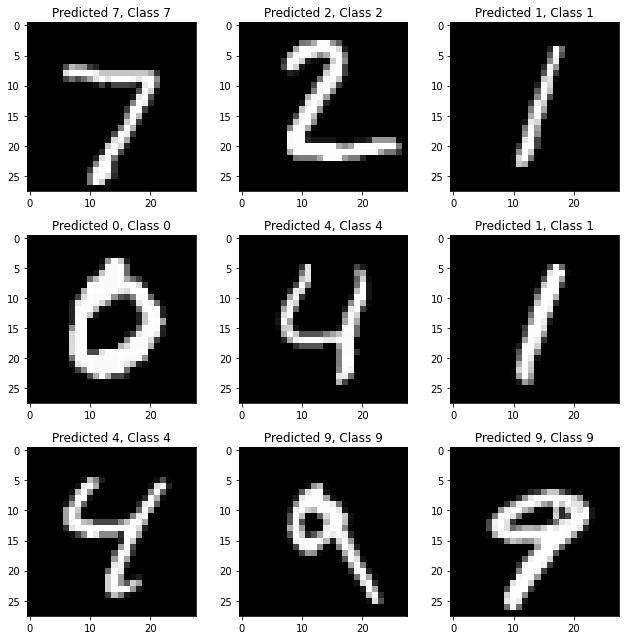

In [65]:
plt.figure(figsize=(9,9))
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    
plt.tight_layout()

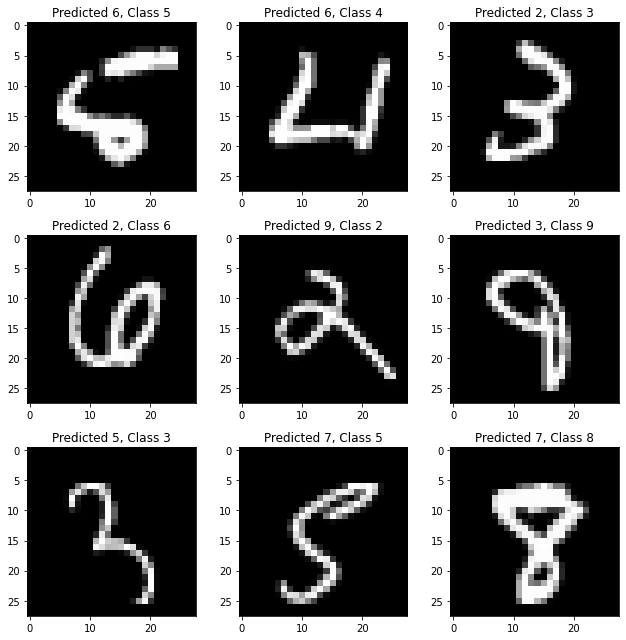

In [62]:
plt.figure(figsize=(9,9))
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    
plt.tight_layout()

### Opdracht 1. De accuracy verhogen

Ga een paar stappen terug en kijk of je de accuracy kunt verhogen. Dat kan op verschillende manieren.
Kijk ook naar de benodigde tijd: duurt het trainen langer of korter?

Speel met:
- epochs
- batch size

**Merk op**: wanneer je meerdere keren achter elkaar `model.fit` aanroept, train je het model steeds verder. Het is dus handig om na elk experiment opnieuw het model op te bouwen om vanaf *scratch* te beginnen. Je kunt ook gebruik maken van de eerder opgeslagen (random) gewichten in `weights_init`, als je dat handig vindt.

In [76]:
model = Sequential()
model.add(Dense(nb_classes, input_shape=(784,)))
model.add(Activation('sigmoid'))
model.add(Dropout(0.2))

# We slaan de parameters van het model op, zodat je ze eventueel
# later kunt gebruiken
weights_init = model.get_weights()  
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train,
          batch_size=80, epochs=6,
          verbose=1) # verbose zorgt voor een animatie van de voortgang
score = model.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/6
750/750 [==============================] - 1s 1ms/step - loss: 3.6414 - accuracy: 0.6900
Epoch 2/6
750/750 [==============================] - 1s 1ms/step - loss: 3.4618 - accuracy: 0.7354
Epoch 3/6
750/750 [==============================] - 1s 1ms/step - loss: 3.4557 - accuracy: 0.7391
Epoch 4/6
750/750 [==============================] - 1s 1ms/step - loss: 3.4466 - accuracy: 0.7426
Epoch 5/6
750/750 [==============================] - 1s 1ms/step - loss: 3.4008 - accuracy: 0.7454
Epoch 6/6
313/313 [==============================] - 0s 577us/step - loss: 0.2766 - accuracy: 0.9234
Test loss: 0.2765965759754181
Test accuracy: 0.9233999848365784


Geef hieronder aan welke accuracy je hebt behaald bij welk aantal epochs en welke batch size. Als je in de buurt bent van 92% accuracy op de testset, dan kun je door naar de volgende opdracht.

batch_size=80, epochs=6
Test accuracy: 0.9233999848365784

### Opdracht 2. Modelling van een completer netwerk
#### Een fully connected 3-layer network
We gaan ons supersimpele netwerk nu uitbouwen tot een fully connected 3-layer network zoals hieronder:

<img src="https://i.imgur.com/1MR9U5c.png" />

#### Waarom meer lagen?!

Het idee is dat een netwerk met meerdere lagen, complexere taken kan uitvoeren. In theorie zou de accuracy voor de MNIST dataset hiermee verhoogd moeten kunnen worden.

### Opdracht 2.a. Het netwerk opbouwen

In [103]:
# We starten weer met het initialiseren van het model
model = Sequential()

#### De eerste laag

In ons eerste model hadden we een input van 784 en output van 10. Nu is de input weer 784 maar de output is een eerste **hidden layer** van 512 neuronen. Voer de volgende zaken uit in cellen hieronder:

1. Gebruik `model.add()` om deze laag toe te voegen aan het model
2. Gebruik de sigmoid als activatiefunctie
3. Voeg de dropout zeroes toe met waarde 0.2

In [113]:
model.add(Dense(512, input_shape=(784,)))

In [114]:
model.add(Activation('sigmoid'))

In [115]:
model.add(Dropout(0.2))

#### De tweede laag

Bij de opvolgende lagen hoef je geen input te definiëren: de vorige laag dient automatisch als input.

- Voeg hieronder nog een laag van 512 neuronen toe aan het model met de sigmoid activatiefunctie en een dropout van 0.2.

In [116]:
model.add(Dense(324))
model.add(Activation('sigmoid'))
model.add(Dropout(0.2))

####  De output laag

De laatste laag heeft 10 elementen, namelijk de 10 klasses. 

- Voeg een laag van 10 neuronen toe aan het model met de activatiefunctie 'softmax'; een dropout is niet nodig.

In [117]:
model.add(Dense(10))
model.add(Activation('sigmoid'))

In [118]:
# Laten we even kijken hoe dat eruit ziet
model.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 512)               401920    
_________________________________________________________________
activation_42 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 1000)              513000    
_________________________________________________________________
activation_43 (Activation)   (None, 1000)              0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_47 (Dense)             (None, 10)              

Als het goed is, ziet de samenvatting van het model hierboven er als volgt uit:

```
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
=================================================================
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
```

NB. Met deze ene extra laag is het totaal aantal te trainen parameters dus gegroeid van 7850 naar __669706__!

#### Compilen

Gebruik dezelfde instellingen voor het compileren van het model.

In [119]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Trainen

Gebruik dezelfde instellingen voor het trainen van het model.

In [120]:
model.fit(X_train, Y_train,
          batch_size=80, epochs=6,
          verbose=1)

Epoch 1/6
750/750 [==============================] - ETA: 0s - loss: 0.7765 - accuracy: 0.72 - 15s 20ms/step - loss: 0.7756 - accuracy: 0.7221
Epoch 2/6
750/750 [==============================] - 22s 29ms/step - loss: 0.1334 - accuracy: 0.9686
Epoch 3/6
750/750 [==============================] - 22s 29ms/step - loss: 0.0942 - accuracy: 0.9767
Epoch 4/6
750/750 [==============================] - 24s 31ms/step - loss: 0.0741 - accuracy: 0.9812
Epoch 5/6
750/750 [==============================] - 25s 33ms/step - loss: 0.0638 - accuracy: 0.9830
Epoch 6/6
750/750 [==============================] - 18s 24ms/step - loss: 0.0570 - accuracy: 0.9845


#### Evalueren

In [121]:
score = model.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 2s 6ms/step - loss: 0.0896 - accuracy: 0.9804
Test loss: 0.0896100327372551
Test accuracy: 0.980400025844574


### Opdracht 2.b.

Hoe goed heeft dit *uitgebreidere* netwerk het gedaan ten opzicht van ons 'supersimpele' netwerk? Als het goed is, al veel beter. Ga ook voor dit netwerk spelen met de epochs en batch size en kijk of je de accuracy kunt verhogen. Kijk ook weer naar de benodigde tijd: duurt het trainen langer of korter?

Speel ook met het aantal neuronen in de hidden layers, wat is het effect als je bijvoorbeeld maar 10 neuronen gebruikt in plaats van 512? Voeg eventueel ook hidden layers toe.

**Merk op:** vergeet niet om bij elk experiment het model opnieuw op te bouwen.

Geef hieronder aan welke accuracy je hebt behaald bij welk aantal epochs en welke batch size. Geef ook de structuur van je netwerk aan, dus het aantal layers en het aantal neuronen per layer.  Als je in de buurt bent van 92% accuracy op de testset, dan kun je door naar de volgende opdracht. Als het goed is, kun je nu tot zo'n 98% komen. Als dat gelukt is, kun je verder gaan met de volgende opdracht.

## Deel II. Blik op de toekomst: deep learning met convolutionele neurale netwerken

### Beperkingen van neurale netwerken

De gevonden resultaten zijn bemoedigend, maar neurale netwerken hebben hun beperkingen. Bekijk onderstaande varianties van een *3* uit de dataset:

<img src="https://i.imgur.com/KfyF1v2.png" />

Het is telkens dezelfde 3 maar dan:
- Verplaatst;
- Verkleurd en ruis op de achtergrond;
- Gedraaid;
- Verkleind;
- Met negatieve kleuren.

In alle gevallen zal ons neuraal netwerk de mist in gaan omdat de pixels van deze drieën afwijken van de pixels van de drieën in de trainset. Je zou dit soort afwijkende drieën kunnen toevoegen aan de trainset maar bij een nieuwe afwijking slaat je netwerk weer eerst de plank mis. 

### Oplossing: kijken zoals mensen kijken

Wanneer wij een plaatje zien, gaan wij niet naar alle pixels kijken en daarmee bepalen of een plaatje een 3 is of iets anders. Wij kijken naar bepaalde patronen, vormen en/of structuren, bijvoorbeeld de drie *pootjes* die een drie heeft of de twee *rondjes* die een acht vormen. We kijken naar scheidingen tussen objecten op een foto of zaken die op de voorgrond of achtergrond staan. Op die manier maken wij onze *voorspellingen*. En dat is precies wat convolutionele neurale netwerken doen.

Voor deze workshop gaat het te ver om ConvNets te behandelen, we bewaren deze materie voor de laatste weken van het vak.

## Deel III. Terug naar het verleden: MNIST met _k_-Nearest Neighbours

Zou het ook mogelijk zijn om cijfers te herkennen met de modellen die we geleerd hebben bij CM? Het is een classificatieprobleem dus regressie en clustering vallen af. Decision Trees zijn niet handig bij grote hoeveelheden features maar kNN kan prima over weg met veel features en in theorie zou je kNN kunnen gebruiken voor de MNIST dataset. Maar werkt het ook in de praktijk?

### Opdracht 3.a. _k_-NN voor MNIST

Duik het verleden in en trek _k_-NN van de plank om een classifier te maken voor de MNIST dataset.

In [123]:
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split   
from sklearn.neighbors import KNeighborsClassifier    # kNN from sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

ModuleNotFoundError: No module named 'sklearn'

Voer de volgende acties uit in de cellen hieronder:

- Gebruik `X_train` en `y_train` om een kNN classifier te fitten. 
- Leg een voorspelling voor `X_test` vast in `y_pred`. 
- Vergelijk deze met `y_test` en bereken de accuracy score.

### Resultaten analyseren

Maak een _confusion matrix_ `cm` door de voorspelde klassen te vergelijken met de werkelijke klassen.

De cel hieronder visualiseert de confusion matrix `cm` voor meer inzicht.

In [ ]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=100)

ax = sns.heatmap(pd.DataFrame(cm), annot=True, cmap='Greens', fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

ax.set_xlabel('voorspelde waarde')
ax.set_ylabel('echte waarde')

plt.show()

print("k-NN (k =", k, ") gefit met", train_items, "items in", stop1-start1, 'seconden')
print("k-NN heeft", test_items, "items voorspeld in", stop2-start2, 'seconden met een test accuracy van ', knn_score)

### Opdracht 3.b. Accuracy verhogen

Speel met de hyperparameters van kNN om de accuracy te verhogen.
Wat valt je op aan de accuracy van kNN t.o.v. het neuraal netwerk? En de performance van kNN t.o.v. het neuraal netwerk?

Geef hieronder de gevonden resultaten aan. Geef in ieder geval aan hoeveel _neighbors_ je hebt gebruikt, wat de afstandsfunctie was en hoe groot je train en je testset waren. Maak ook een vergelijking in performance tussen het neurale netwerk en _k_-NN.

Als het goed is, kun je nu tot zo'n 97% komen. Als dat gelukt is, ben je klaar.

### Beperkingen van kNN

kNN doet het harstikke goed voor MNIST. Maar we hebben het hier over plaatjes van 28 x 28 pixels die eigenlijk zwart wit zijn. Wat als we complexere plaatjes zouden gebruiken? Of plaatjes van 1920x1080 pixels? De performance van kNN wordt dan dramatisch en de accuracy is dan ook bedroevend...

#### Fashion MNIST
De Fashion MNIST dataset lijkt op MNIST, maar de plaatjes zijn iets complexer. Kledingstukken lijken qua vorm meer op elkaar en er wordt gebruik gemaakt van meerdere grijstinten. 

<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/02/Plot-of-a-Subset-of-Images-from-the-Fashion-MNIST-Dataset-1024x768.png" />

De accuracy van kNN duikt voor deze dataset al richting de 85%... niet best dus... en we hebben het hier nog steeds over superkleine plaatjes. Moet je na gaan wat er gebeurt bij grotere plaatjes.

Enfin, als je het leuk vindt om met de Fashion MNIST dataset aan de slag te gaan, gebruik dan de volgende code: 
- `fashion_mnist = tf.keras.datasets.fashion_mnist`
- `(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()`

## Conclusies

Hopelijk heb je door deze workshop een beter beeld van wat neurale netwerken zijn en hoe ze werken en hebben we jullie gemotiveerd voor de cursus Machine Learning!